# Admixture Graph Demo

In [1]:
import logging
import os
import momi
import sys
from admixture_graph import *
from mcmc import *
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from networkx.algorithms.cycles import find_cycle
import matplotlib.pyplot as plt

os.chdir('..')

## Create an example admixture graph

In [2]:
def generate_easy_example_graph():
    topology = admixture_graph()
    topology.add_edge('RT', '1')
    topology.add_edge('RT', 'D')
    topology.add_edge('1','2')
    topology.add_edge('1','3')
    topology.add_edge('2','A')
    topology.add_edge('2','4')
    topology.add_edge('3','C')
    topology.add_edge('4','B')
    # admixture  edge
    topology.add_edge('3','4')
    return topology

g = generate_easy_example_graph()

In [3]:
g

## Set up events

In [3]:
# nodes
ns = ['RT', 'A', 'B', 'C', 'D',
      '1', '2', '3', '4']

# set event time
ts = [1e5, 0, 0, 0, 0,
      6e4, 1e4, 2e3, 2e3]
t_event = dict()
for i, n in enumerate(ns):
    t_event[n] = ts[i]
g.set_event_time(t_event)

# set event type
types = ['merge'] * 9
types[7] = 'admixture'; types[8] = 'admixture'
types_dict = dict()
for i, n in enumerate(ns):
    types_dict[n] = types[i]
g.set_event_type(types_dict)

# set admixture_proportion
prop = {('3','4'): 0.3}
g.set_admixture_proportion(prop)

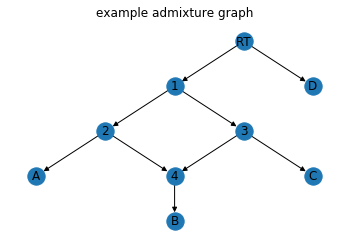

In [7]:
plot_graph(g, 'example admixture graph')

## Some properties of the admixture_graph object

In [13]:
dir(g)[40:]

['add_node',
 'add_nodes_from',
 'add_path',
 'add_star',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'copy',
 'degree',
 'draw_random_branch',
 'edge_attr_dict_factory',
 'edge_subgraph',
 'edges',
 'fresh_copy',
 'get_admixture_edges',
 'get_admixture_events',
 'get_admixture_proportions',
 'get_branches_at_time',
 'get_edge_data',
 'get_event_time',
 'get_event_type',
 'get_events',
 'get_leaf_nodes',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'inner_nodes',
 'is_admixture_edge',
 'is_directed',
 'is_event_order_feasible',
 'is_multigraph',
 'lower_bound_node',
 'name',
 'nbunch_iter',
 'neighbors',
 'node',
 'node_attr_dict_factory',
 'node_dict_factory',
 'nodes',
 'nodes_with_selfloops',
 'number_of_edges',
 'number_of_nodes',
 'number_of_selfloops',
 'order',
 'out_degree',
 'out_edges',
 'parent_merge_node',
 'pred

In [10]:
print(f'branches existing at time 20000: {g.get_branches_at_time(20000)}')
print(f'events times: {g.get_events()}')
print(f'admixture_edges: {g.get_admixture_proportions()}')
print(f'event feasible?: {g.is_event_order_feasible()}')
print(f'leaves: {g.get_leaf_nodes()}')
print(f'topology: {g.to_newick()}')

branches existing at time 20000: [('RT', 'D'), ('1', '2'), ('1', 'C')]
events times: [('3', 2000.0), ('4', 2000.0), ('2', 10000.0), ('1', 60000.0), ('RT', 100000.0)]
admixture_edges: {('3', '4'): 0.3}
event feasible?: True
leaves: ['D', 'A', 'C', 'B']
topology: {'tree': '(((A,B),C),D)', 'admixture': ['(C)', '(B)']}


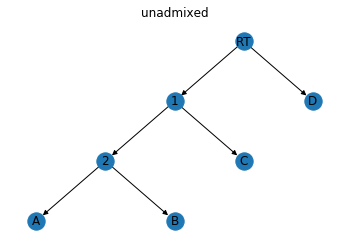

In [18]:
g_unadmixed = g.to_unadmixed_tree()
plot_graph(g_unadmixed, 'unadmixed')

## Convert our admixture graph into a momi demography object

In [14]:
demography = g.to_demography(print_events=True)
demography

move from A to B at t = 10000.00
move from B to C at t = 60000.00
move from C to D at t = 100000.00
move from B to C at t = 2000.00 and proportion = 0.3


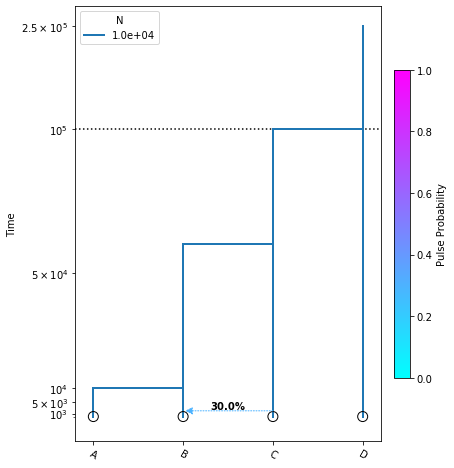

In [15]:
%matplotlib inline
yticks = [1e3, 5e3, 1e4, 5e4, 1e5, 2.5e5]

fig = momi.DemographyPlot(
    demography, ["A", "B", "C", "D"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,1))

## proposal for regrafting admixture events

move from A to B at t = 10000.00
move from B to C at t = 60000.00
move from C to D at t = 100000.00
move from D to C at t = 71018.92 and proportion = 0.3


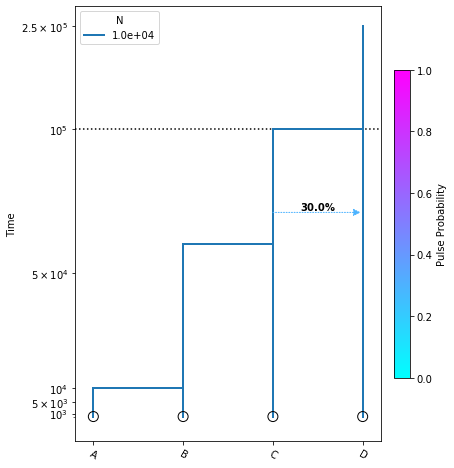

In [20]:
prefix = 'admixed_4pops.rep'
rep = '1'
sfs = f"data/sfs_{prefix}{rep}.gz"
sfs = momi.Sfs.load(f"data/sfs_{prefix}{rep}.gz")
demography.set_data(sfs)

%matplotlib inline
random.seed(101)
g2, ratio = admixture_edge_proposal(g, print_output=False)
demography2 = g2.to_demography(print_events=True)
demography2.set_data(sfs)

yticks = [1e3, 5e3, 1e4, 5e4, 1e5, 2.5e5]

fig = momi.DemographyPlot(
    demography2, ["A", "B", "C", "D"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,1))

In [21]:
print(f'current topology: {g.to_newick()}')
print(f'topology proposed: {g2.to_newick()}')

current topology: {'tree': '(((A,B),C),D)', 'admixture': ['(C)', '(B)']}
topology proposed: {'tree': '(((A,B),C),D)', 'admixture': ['((A,B),C)', '(D)']}


In [26]:
new_time, _ = event_time_proposal_randomwalk(g)
print(f'current time: {dict(g.get_events())}')
print(f'event times proposed: {new_time}')

current time: {'3': 2000.0, '4': 2000.0, '2': 10000.0, '1': 60000.0, 'RT': 100000.0}
event times proposed: {'3': 687.3006517346439, '4': 687.3006517346439, '2': 10327.991747089953, '1': 61368.67358416683, 'RT': 107999.51998061068}


In [23]:
new_admixture_proportion , q = admixture_proportion_proposal(g)
print(f'current admixture proporion: 0.3')
print(f'admixture proporion proposed: {new_admixture_proportion}')

current admixture proporion: 0.3
admixture proporion proposed: {'3_4_proportion': 0.24438840447953522}


In [27]:
new_time, _, scale = event_time_proposal_multiplicative(g)
print(f'current time: {dict(g.get_events())}')
print(f'scale: {scale}')
print(f'event times proposed: {new_time}')

current time: {'3': 2000.0, '4': 2000.0, '2': 10000.0, '1': 60000.0, 'RT': 100000.0}
scale: 0.14397455080908667
event times proposed: {'3': 287.94910161817336, '4': 287.94910161817336, '2': 1439.7455080908667, '1': 8638.4730485452, 'RT': 14397.455080908667}


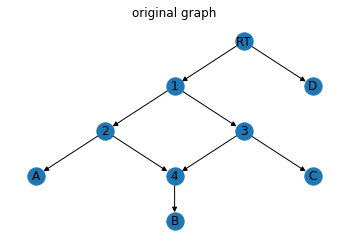

events: [('3', 2000.0), ('4', 2000.0), ('2', 10000.0), ('1', 60000.0), ('RT', 100000.0)]
candidate_pruned_nodes: ['2', 'A', 'C', 'B']
pruned: A; its parent 2
lower bound node : A
reconnet edge(1,4)


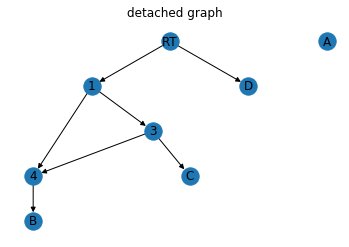

False
add edge: ('3', '2'),('2', 'C'), ('2', 'A')
lower_upper = (0,2000.0)
ag.set_event_time(2:1362.3515608676864)
detach node A; regraft to branch ('3', 'C')


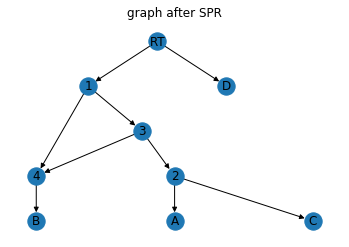

In [56]:
g_spr_proposed, q = SPR(g, print_output= True, locate_cycle = True)
#plot_graph(g_spr_proposed, 'SPR proposed graph')